In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import re

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score

# Visualization (Optional)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load files
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

# Sample to balance memory/performance
ratings_sampled = ratings.sample(n=30000, random_state=42)

# Merge ratings with movie metadata
ratings_sampled = ratings_sampled.merge(movies, on='movieId', how='left')

# Create binary label: liked if rating >= 4
ratings_sampled['liked'] = (ratings_sampled['rating'] >= 4).astype(int)


In [3]:
# Extract year from movie title
def extract_year(title):
    match = re.search(r'\((\d{4})\)', str(title))
    return int(match.group(1)) if match else np.nan

ratings_sampled['year'] = ratings_sampled['title'].apply(extract_year)

# User-level features
ratings_sampled['user_activity'] = ratings_sampled.groupby('userId')['movieId'].transform('count')
ratings_sampled['user_avg_rating'] = ratings_sampled.groupby('userId')['rating'].transform('mean')

# One-hot encode genres
ratings_sampled['genres'] = ratings_sampled['genres'].apply(lambda x: str(x).split('|'))
mlb = MultiLabelBinarizer()
genre_dummies = mlb.fit_transform(ratings_sampled['genres'])
genre_df = pd.DataFrame(genre_dummies, columns=mlb.classes_)

# Combine genre features with main DataFrame
ratings_sampled = pd.concat([ratings_sampled.reset_index(drop=True), genre_df], axis=1)


In [4]:
# Define final features
feature_cols = mlb.classes_.tolist() + ['year', 'user_activity', 'user_avg_rating']

# Drop rows with missing year
ratings_sampled.dropna(subset=feature_cols, inplace=True)

# Create training data
X = ratings_sampled[feature_cols]
y = ratings_sampled['liked']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print("Improved Random Forest Accuracy:", round(rf_accuracy * 100, 2), "%")


Improved Random Forest Accuracy: 92.44 %


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
# Load only a sample to avoid memory issues
imdb_reviews = pd.read_csv("IMDB Dataset.csv", nrows=20000)

# Check data
imdb_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# Convert sentiment labels to binary
imdb_reviews['sentiment'] = imdb_reviews['sentiment'].map({'positive': 1, 'negative': 0})

# TF-IDF vectorization of review text
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(imdb_reviews['review'])
y = imdb_reviews['sentiment']

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict and evaluate
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

print("🎯 Logistic Regression Accuracy (Sentiment):", round(lr_accuracy * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, lr_pred))


🎯 Logistic Regression Accuracy (Sentiment): 85.08 %

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      2048
           1       0.83      0.87      0.85      1952

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



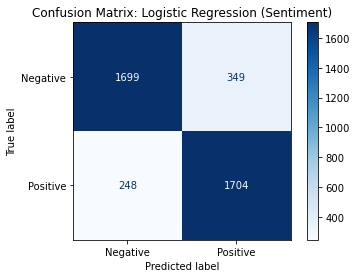

In [9]:
# Plot confusion matrix
cm = confusion_matrix(y_test, lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression (Sentiment)")
plt.show()

In [10]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

In [12]:
# Load datasets
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

# Sample for memory efficiency
ratings_sampled = ratings.sample(n=30000, random_state=42)
ratings_sampled = ratings_sampled.merge(movies, on='movieId', how='left')

# Target: binary label (like/dislike)
ratings_sampled['liked'] = (ratings_sampled['rating'] >= 4).astype(int)

# Extract year from movie title
def extract_year(title):
    match = re.search(r'\((\d{4})\)', str(title))
    return int(match.group(1)) if match else np.nan

ratings_sampled['year'] = ratings_sampled['title'].apply(extract_year)

# User behavior features
ratings_sampled['user_activity'] = ratings_sampled.groupby('userId')['movieId'].transform('count')
ratings_sampled['user_avg_rating'] = ratings_sampled.groupby('userId')['rating'].transform('mean')

# Genre encoding
ratings_sampled['genres'] = ratings_sampled['genres'].apply(lambda x: str(x).split('|'))
mlb = MultiLabelBinarizer()
genre_dummies = mlb.fit_transform(ratings_sampled['genres'])
genre_df = pd.DataFrame(genre_dummies, columns=mlb.classes_)
ratings_sampled = pd.concat([ratings_sampled.reset_index(drop=True), genre_df], axis=1)


In [13]:
# Define features
feature_cols = mlb.classes_.tolist() + ['year', 'user_activity', 'user_avg_rating']
ratings_sampled.dropna(subset=feature_cols, inplace=True)

X = ratings_sampled[feature_cols]
y = ratings_sampled['liked']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

print("🎯 XGBoost Accuracy (Like Prediction):", round(xgb_accuracy * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, xgb_pred))


C:\Users\Lenovo\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [17:47:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🎯 XGBoost Accuracy (Like Prediction): 92.24 %

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92      3029
           1       0.94      0.90      0.92      2964

    accuracy                           0.92      5993
   macro avg       0.92      0.92      0.92      5993
weighted avg       0.92      0.92      0.92      5993



In [14]:
results = pd.DataFrame({
    'Model': [
        'Improved Random Forest Accuracy',
        '🎯 Logistic Regression Accuracy (Sentiment)',
        '🎯 XGBoost Accuracy (Like Prediction)'
    ],
    'Accuracy (%)': [
        round(rf_accuracy * 100, 2),      # make sure rf_accuracy exists
        round(lr_accuracy * 100, 2),      # make sure lr_accuracy exists
        round(xgb_accuracy * 100, 2)      # from XGBoost section
    ]
})

print("\nModel Performance Summary:")
print(results)



Model Performance Summary:
                                        Model  Accuracy (%)
0             Improved Random Forest Accuracy         92.44
1  🎯 Logistic Regression Accuracy (Sentiment)         85.08
2        🎯 XGBoost Accuracy (Like Prediction)         92.24


In [15]:
from xgboost import XGBClassifier
import joblib

# Train model (if not trained already)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "movie_like_predictor.pkl")


C:\Users\Lenovo\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [17:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['movie_like_predictor.pkl']

In [16]:
joblib.dump(mlb, "genre_encoder.pkl")


['genre_encoder.pkl']